# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize,
        labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [14]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [15]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

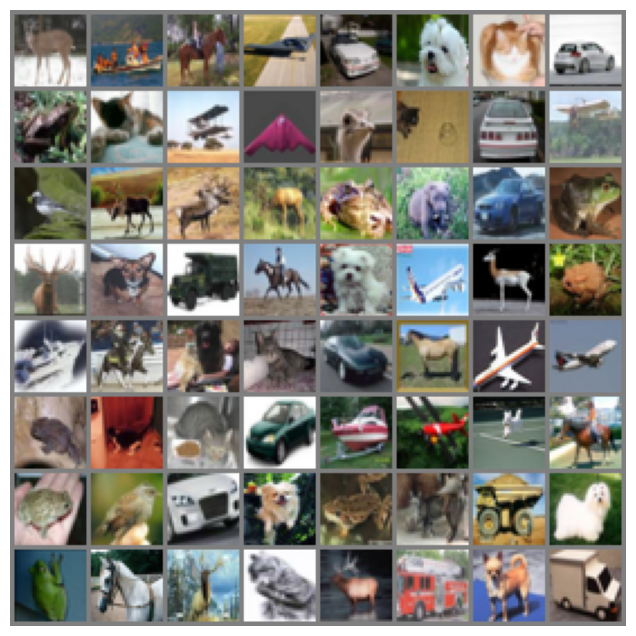

In [16]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [17]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        # Your code here!
        
        # self.network = nn.Sequential(
        #     nn.Conv2d(3, 6, 5, padding=1, stride=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2,2),
        #     nn.Conv2d(6, 16, 5, padding=1, stride=1),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2,2),
        #     nn.Flatten(),
        #     nn.Linear(16*6*6, 120),
        #     nn.ReLU(),
        #     nn.Linear(120, 84),
        #     nn.ReLU(),
        #     nn.Linear(84, num_classes),
        #     nn.Softmax(dim=1)
        # )
        
        
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, stride=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.25)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1, stride=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout(0.25)
        
        
        self.fc1 = nn.Linear(128*4*4, 1024)  # Adjusted dimensions
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.log_softmax = nn.LogSoftmax(dim=1)
        

    def forward(self, x):
        # Your code here!
        # x = self.network(x)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x) # 32x16x16
        x = self.bn1(x)
        x = self.dropout1(x)
        
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool(x) # 64x8x8
        x = self.bn2(x)
        x = self.dropout2(x)
        
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.pool(x) # 128x4x4
        x = self.bn3(x)
        x = self.dropout3(x)    
        
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.log_softmax(x)
        return x


model = Model(n_classes)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  # use cuda or cpu
model.to(device)
print(model)

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)

## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [18]:
loss_fn = nn.CrossEntropyLoss()  # Your code here!
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Your code here!½

## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [7]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[-2.3707845 -2.2477982 -2.3099995 -2.33945   -2.1627324 -2.145248
  -2.4043763 -2.411063  -2.2262979 -2.4615731]
 [-2.2420523 -2.3263404 -2.306213  -2.2329152 -2.2015226 -2.2332208
  -2.4958384 -2.3687897 -2.3119428 -2.3398004]]
Output probabilities:
[[0.09340742 0.10563156 0.09926131 0.09638065 0.11501045 0.11703902
  0.09032182 0.08971988 0.10792726 0.08530066]
 [0.10624025 0.09765247 0.09963788 0.10721543 0.11063458 0.10718266
  0.08242732 0.09359395 0.0990686  0.09634688]]


In [8]:
batch_size = 64
num_epochs = 100
validation_every_steps = 1000

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        # Your code here!
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, targets)
        loss.backward()
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Step 1000    training accuracy: 0.5571244266055045
             test accuracy: 0.5048
Step 2000    training accuracy: 0.6575759747706422
             test accuracy: 0.6703
Step 3000    training accuracy: 0.7119409403669725
             test accuracy: 0.713
Step 4000    training accuracy: 0.7659722222222223
             test accuracy: 0.7576
Step 5000    training accuracy: 0.7791193181818182
             test accuracy: 0.7688
Step 6000    training accuracy: 0.7980038022813688
             test accuracy: 0.7854
Step 7000    training accuracy: 0.8112189180107527
             test accuracy: 0.7992
Step 8000    training accuracy: 0.8341145833333333
             test accuracy: 0.8013
Step 9000    training accuracy: 0.8422581658291457
             test accuracy: 0.8102
Step 10000   training accuracy: 0.8498883928571429
             test accuracy: 0.8165
Step 11000   training accuracy: 0.8671875
             test accuracy: 0.8227
Step 12000   training accuracy: 0.8758101851851852
             

KeyboardInterrupt: 

`NOTE THAT THE TRAINING WAS STOPPED EARLY, because of impatience and that the accuracies were not improving.`

## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

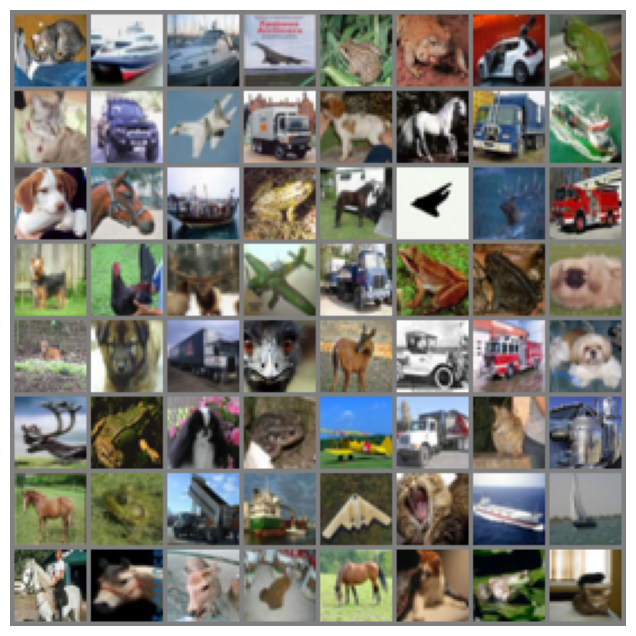

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship          ship     
    ship          ship     
  airplane      airplane   
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          frog     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog           dog     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse         horse    
    ship          ship     
    frog          frog     
    horse         horse    
  airplane        bird     
    deer          deer     
    truck         truck    
     dog          deer     
    bird          bird     
    deer          deer     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          frog     
     dog           dog     
    deer          deer     
     dog           c

In [33]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [26]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [27]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.856


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


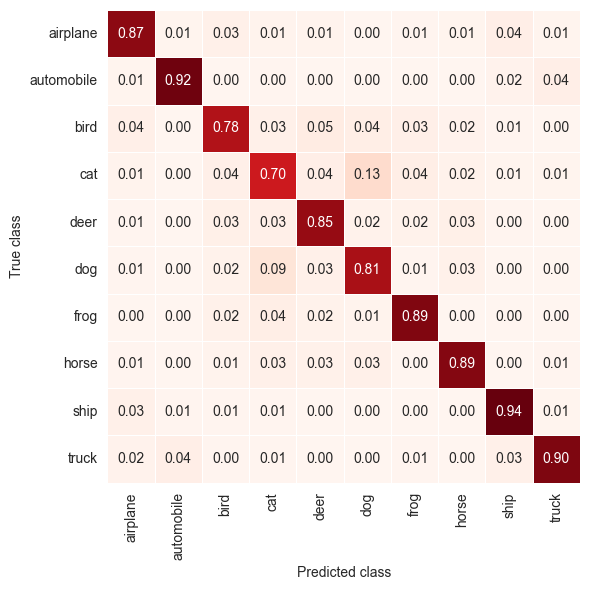

In [28]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

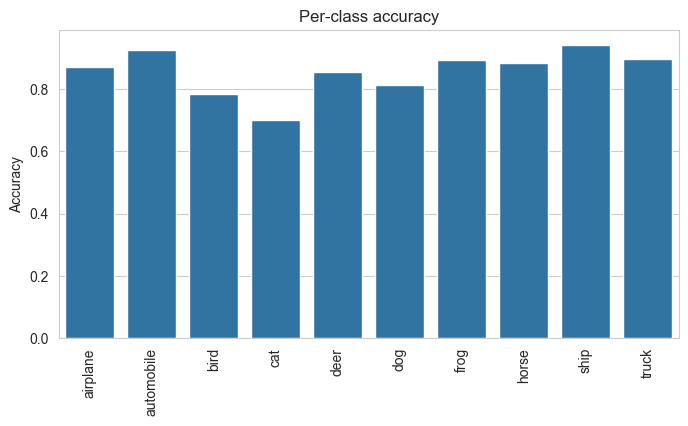

In [29]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

In [14]:
# Save model to file
# torch.save(model.state_dict(), "model_cifar10.pth")

In [23]:
#load model
model = Model(n_classes)
model.load_state_dict(torch.load("model_cifar10.pth"))

C:\Users\marku\AppData\Local\Temp\ipykernel_26844\2578461840.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_cifar10.pth"))


<All keys matched successfully>

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.

**Answer:**

A simple minimal CNN with 2 convolutional layers [minimal kernel size and features] and 2 fully connected layers yields only 10% accuracy after 10 epochs. Examining the confusion matrix, it is indicated that the model is still learning and attempting at guessing a variety of classes. Therefore the epochs are increased to 50, in which the model sits at a static 58% training and testing accuracy after around 30 epochs. Further increasing the complexity of the model by adding more convolutions increases the test accuracy to 70% and training accuracy to 99% indicating overfitting, which can be seen at the following graph snapshot.

![image.png](overfit.png)

To combat the overfit, dropout layers are added to the model as well as batchnormalization layers, which brings the model to 96% training accuracy and 84% testing accuracy. The model is still overfitting, but the gap is significantly smaller and the test accuracy is also significantly greater. The confusion matrix indicates that the model is still struggling with classifying certain classes, such as the cat class.


Key lessons/insights:
- Convolutional layers are very powerful in image classification tasks
- Dropout layers are very useful in preventing overfitting
- It is essential to train a model over multiple epochs to allow it to learn the data


Notice that the training did not run to the end of the epoch, since the momentum of the accuracies stagnated and I wasn't bothered to continue the training.

# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [14]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Available CUDA devices: ['NVIDIA GeForce GTX 1080 Ti']


You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

**Answer:**





Exercise Chapter 1, can be found <a href="http://neuralnetworksanddeeplearning.com/chap1.html#exercise_717502">here</a>

![image.png](exercise.png)

Given equation 22 from the book

$$
a' = \sigma(w a + b)
$$

Where $\sigma$ is the sigmoid function $\sigma(z) = \frac{1}{1 + e^{-z}}$, which yields the following.

$$
a' = \frac{1}{1 + e^{-(w a + b)}}
$$

Then assuming that there are multiple inputs $x_1, x_2, ...$ we can rewrite the equation as a sum of the weighted inputs.

$$
a' = \frac{1}{1 + e^{-\sum_{j}{w_j x_j} - b}}
$$

Which matches the expression for the fourth equation in the book

$$
\sigma(z) = \frac{1}{1 + e^{-\sum_{j}{w_j x_j} - b}}
$$